# Lightning Detection Demo

This notebook shows a method of detection where in the picture a lightning could be located. Furthermore it is a method to detect areas of unusual brightness.

## Setting up the program

Obviously the program needs to have the commom data-wrangling packages: scipy, numpy, matplotlib etc.

The package imageio is needed to load the image files as numpy arrays, as scipy is deprecating the *misc.imread* function within the next versions!

Additionally the package lightnimage is needed. It is a wrapper for the common operations used in the detection process such as calculating the difference of two images as well as, for example the row and column sums across an image.

To install the **lightnimage** package, just type into the command line:

```bash
#~ pip3 install lightnimage
```

In [ ]:
# built in imports
import os

# Third party imports 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imageio
import numpy

# local imports
from lightnimage.image import LightningImage
from lightnimage.engine import SimpleAreaSegmentationEngine
from lightnimage.engine import SimpleAreaGroupingEngine


To work properly the program needs *two* pictures: One being the one to process and detect lightning on, the other being a reference picture. Reference means, that it should possibly display the same scene, but *without a lightning*. This is most of the time a reasonable requirement, as when looking at a video, the frame just before the lightning burst could be used for example.

In [2]:
# Defining the pictures for the analysis
FOLDER_PATH = '/home/jonas/Nextcloud/Programmieren/PyCharm/aragats/data'
REFERENCE_IMAGE_NAME = 'aragats-0181.jpg'
DETECTION_IMAGE_NAME = 'aragats-0186.jpg'


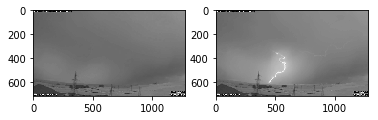

In [3]:
# Creating the actual paths from these file names
reference_image_path = os.path.join(FOLDER_PATH, REFERENCE_IMAGE_NAME)
detection_image_path = os.path.join(FOLDER_PATH, DETECTION_IMAGE_NAME)

# Loading the pictures into memory as gray scale value matrices
reference_image_array = imageio.imread(reference_image_path, pilmode='L')
detection_image_array = imageio.imread(detection_image_path, pilmode='L')

# Creating the LightningImage objects based on these matrices
reference_lightning_image = LightningImage(reference_image_array)
detection_lightning_image = LightningImage(detection_image_array)

# Showing the pictures to be used 
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(reference_image_array, cmap='gray')
ax2.imshow(detection_image_array, cmap='gray')

## Preprocessing

For preprocessing the difference of the actual image and the reference is calculated. Since they both display the same scene, with the only real difference being the lightning, the backgorund is mostly removed.

But a little bit of the bg still remains. The picture is then further processed by just turning all pixels below a certain threshold to pure black and those above to pure white (255 gray scale value).

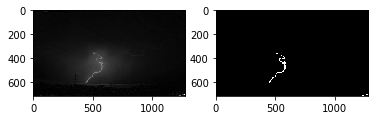

In [4]:
# This is the gray scale threshold for the light/dark segmentation of the picture
# Everything below it will be set to absolute black and everything above will be white
THRESHOLD = 80

# Calculating the difference of the two to get rid of the timestamps and most of the background
difference_lightning_image = detection_lightning_image - reference_lightning_image

# Darkening the already dark parts more and brightening the already bright parts more
binary_lightning_image = difference_lightning_image.copy()
binary_lightning_image.lighten(THRESHOLD)
binary_lightning_image.darken(THRESHOLD - 1)

f, (ax2, ax3) = plt.subplots(1, 2)
ax2.imshow(difference_lightning_image.array, cmap='gray')
ax3.imshow(binary_lightning_image.array, cmap='gray')


## How it works

The detection engine computes the sums of the gray scale values along each column and along each row. These sums form two data sets aling these axes. These data sets have very distinct peaks, which are detected by using a threshold value (relative to the average of the whole set). Like this there will be one, possibly multiple sequences along the axes of the image, where those sums have exceeded the threshold. It will result in a list of start and end indices for these sequences for both the x and y axis:

```python
x_sequences = [(23, 187), (199, 786)]
y_sequences = [(100, 320), (600, 700)]
```

These one dimensional stretches along the axis are then used to create every possible combination of x and y sequences resulting in a number of 2 dimensional areas (which are defined by the start and end index along x and y) where a anomaly *could* be:

```python
areas = [
    ((23, 187), (100, 320)),
    ((199, 786), (100, 320)),
    ((23, 187), (600, 700)),
    ((199, 786), (600, 700))
]
```

### False positives

This technique obviously creates a lot of wrong areas. To remove those false positives each area is checked, by calculating the average gray scale value of every pixel *within an area* and if it does not match a certain threshold, that can be expected, when looking for unussually bright areas, that area is discarded from the final result.
The left over is 

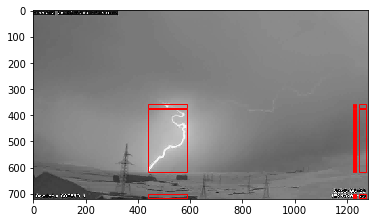

In [5]:
# Running the Area segmentation engine on the final result of the pre processing, which is essentially a binary picture
# Where the lightning pixels have a value of 255 and the others a value of 0.
DETECTION_THRESHOLD = 1.0


def draw_areas(ax, areas):
    for area in areas:
        # Calculating the start point (upper right corner) and the width length of the area, because they are needed 
        # to draw the rectangle into the plot
        start = (area[0][0], area[1][0])
        width = area[0][1] - area[0][0]
        height = area[1][1] - area[1][0]
        
        # Drawing over the picture
        rect = patches.Rectangle(start, width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)


# We first run the detection algorithm without validity checks to illustrate the working principle 
detection_config = {
    'threshold':    DETECTION_THRESHOLD,
    'checking':     False
}
segmentation_engine = SimpleAreaSegmentationEngine(detection_config)
areas = segmentation_engine(binary_lightning_image)

f, ax4 = plt.subplots(1, 1)
ax4.imshow(detection_image_array, cmap='gray')

# Overlaying the detected areas with the original picture
draw_areas(ax4, areas)


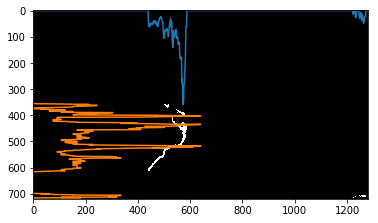

In [6]:
# Here we illustrate how the detection algorithm works basically
# It just detects anomalies in the vertical and horizontal sum functions of the picture
y_sum = binary_lightning_image.column_sum(scale=binary_lightning_image.width/2)
x_sum = binary_lightning_image.row_sum(scale=binary_lightning_image.height/2)

# We plot the sums into the same picture
x = numpy.arange(0, binary_lightning_image.width)
y = numpy.arange(0, binary_lightning_image.height)

f, ax5 = plt.subplots(1, 1)
ax5.imshow(binary_lightning_image.array, cmap='gray')
ax5.plot(x, x_sum)
ax5.plot(y_sum, y)

In [ ]:
# Now we are doing the same thing, but with the checking enabled.
# The checking will get rid of all the areas, which do not contain "enough optical mass" to be recognized as lightnings.
# Removing all the false positives, that were created through the one dimensional area algorithm
segmentation_engine.config['checking'] = True
areas = segmentation_engine(binary_lightning_image)

f, ax6 = plt.subplots(1, 1)
ax6.imshow(detection_image_array, cmap='gray')

draw_areas(ax6, areas)


NameError: name 'SimpleAreaGroupingEngine' is not defined

In [1]:
# Now we group the areas together
grouping_config = {
    'threshold':    10**4
}
grouping_engine = SimpleAreaGroupingEngine(grouping_config)
grouped_areas = grouping_engine(areas)

f, ax7 = plt.subplots(1, 1)
ax7.imshow(detection_image_array, cmap='gray')

draw_areas(ax7, grouped_areas)


NameError: name 'SimpleAreaGroupingEngine' is not defined

## Open issues 

### Relative Thresholding

Using a threshold realtive to the average, when detecting peaks in the column- and row-sums has shown to have some issues: When there are two lightnings in the picture, with one being a lot dimmer than the other, only the bright one is being detected, because the bright one is contributing most to the average of the sums.

A possible solution would be to just completely remove the detected areas from the original picture and run the whole program on it multiple times until nothing is being detected anymore.

Additionally the relative thresholding should be replaced with just using a callback function in the config, so a custom calculation can be used to compare the threshold against.

### On the edge of the threshold

Another problem occurs, when the lightning has just the right brightness, so that the threshold value, which detects the peaks of the sum functions was calculated in such a ways, that it detects *too many, small* peaks. The result is not one area around the entirety of the lightning, but many small areas around various parts of the lightning and sometimes the terrain as well (!)

A possible solution would be to use a grouping engine after the detection engine, which would group together some areas, based on A) how far they are apart (lower the probability) and B) How big they are (smaller areas are more likely to be false positive)